# Data Discretization and Gaussian Mixture Models

The purpose of this notebook is to explore the use of Gaussian Mixture Models (GMMs) to discretize data. Here, we generate dummy data from 2 populations (male children and female children). The features that we generate are all gaussians and hypothetical around height, weight and sleep, denoted as $X_0$, $X_1$ and $X_2$, respectively. For the male children, these variables are sampled as follows.

* $X_0 \sim \mathcal{N}(60, 5)$
* $X_1 \sim \mathcal{N}(50 + 0.5 X_0, 20)$
* $X_2 \sim \mathcal{N}(1 + 0.1 X_1, 1.5)$

For the female children, these variables are sampled as follows.

* $X_0 \sim \mathcal{N}(50, 5)$
* $X_1 \sim \mathcal{N}(45 + 0.5 X_0, 10)$
* $X_2 \sim \mathcal{N}(1.5 + 0.1 X_1, 1.5)$

In [1]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import stats

random.seed(37)
np.random.seed(37)
plt.style.use('ggplot')

def get_m_ch_data(N=1000):
    h = np.random.normal(60, 5, N)
    w = np.random.normal(50 + 0.5 * h, 20, N)
    s = np.random.normal(1 + 0.1 * w, 1.5, N)
    return np.concatenate([h.reshape(-1, 1), w.reshape(-1, 1), s.reshape(-1, 1)], axis=1)

def get_f_ch_data(N=1000):
    h = np.random.normal(50, 5, N)
    w = np.random.normal(45 + 0.5 * h, 10, N)
    s = np.random.normal(1.5 + 0.1 * w, 1, N)
    return np.concatenate([h.reshape(-1, 1), w.reshape(-1, 1), s.reshape(-1, 1)], axis=1)

def get_data(N=1000):
    m_ch = get_m_ch_data(N)
    f_ch = get_f_ch_data(N)
    return np.concatenate([m_ch, f_ch], axis=0)

In [2]:
X = get_data()

## Visualization

Here are some visualization of the variables. Had we not known that the full data comes from two populations, it is difficult to tell from the univariate, bivariate and multivariate plots if there are any clusters.

### Univariate Density Plot

With the exception of $X_0$, all variables seem like well-behaved gaussian distributed variables. For $X_0$, there is a hump that visually detectable.

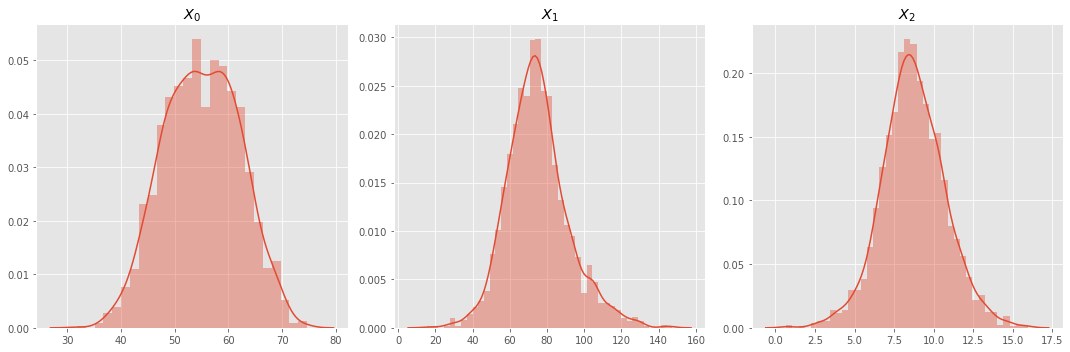

In [3]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for c in range(X.shape[1]):
    sns.distplot(X[:,c], ax=ax[c])
    ax[c].set_title(r'$X_{}$'.format(c))

plt.tight_layout()

### Bivariate Density Plots

These are pairwise density plots for the three variables. For $X_0$ vs $X_1$ and $X_0$ vs $X_2$, there seems to be a skewing to the top right. Again, not indicative of any clusters or anything separable along the pairwise dimensions.

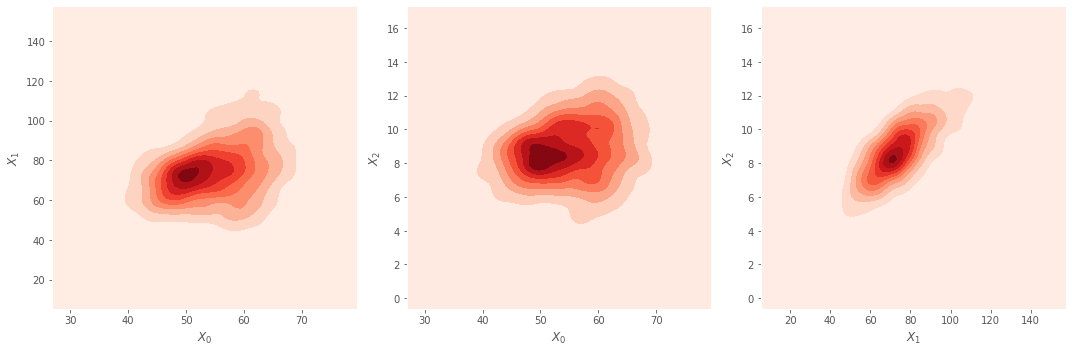

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.kdeplot(X[:,0], X[:,1], ax=ax[0], cmap="Reds", shade=True)
sns.kdeplot(X[:,0], X[:,2], ax=ax[1], cmap="Reds", shade=True)
sns.kdeplot(X[:,1], X[:,2], ax=ax[2], cmap="Reds", shade=True)

ax[0].set_xlabel(r'$X_0$'); ax[0].set_ylabel(r'$X_1$'); 
ax[1].set_xlabel(r'$X_0$'); ax[1].set_ylabel(r'$X_2$'); 
ax[2].set_xlabel(r'$X_1$'); ax[2].set_ylabel(r'$X_2$'); 

plt.tight_layout()

### Multivariate Scatter Plot

Here's a scatter plot. It looks nice as a 3-D plot, but not telling of any patterns. 

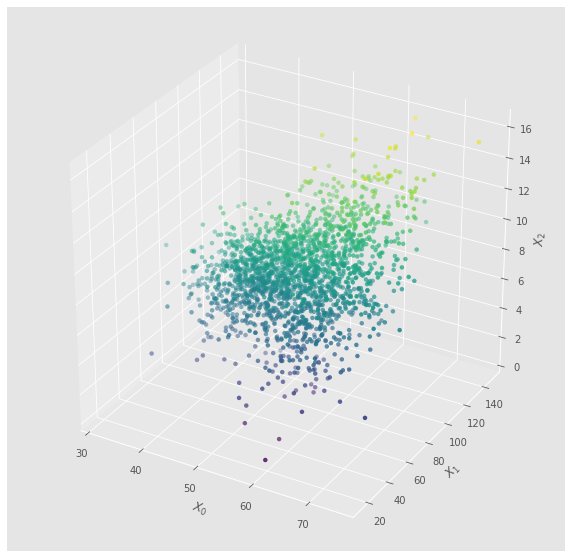

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:,0], X[:,1], X[:,2], c=X[:,2], cmap='viridis', linewidth=0, antialiased=True)
ax.set_xlabel(r'$X_0$')
ax.set_ylabel(r'$X_1$')
_ = ax.set_zlabel(r'$X_2$')

## Gaussian Mixture Model (GMM)

Now, let's see if we may use GMM as an unsupervised learning technique to recover any meaningful clusters in the full data. When we use GMM, we iterate from 2 to 5 (inclusive both ends) and observe the associated [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) score (a lower AIC is better). Using GMM, we discover that when the number of components is 2, that model has the lowest AIC score. This observation already is promising, as we know that there are 2 populations and GMM (with the number of components set to 2) has basically recovered the clusters.

In [6]:
from sklearn.mixture import GaussianMixture

def get_gmm_labels(X, k):
    gmm = GaussianMixture(n_components=k, max_iter=50, random_state=37)
    gmm.fit(X)
    aic = gmm.aic(X)
    bic = gmm.bic(X)
    return aic, bic, k, gmm

gmm_scores = [get_gmm_labels(X, k) for k in range(2, 6)]
gmm_scores = sorted(gmm_scores, key=lambda tup: (tup[0], tup[2]))
gmm = gmm_scores[0][3]

Look at the means. They are nearly identical to the expected values for each cluster.

In [7]:
gmm.means_

array([[51.2556073 , 71.25912453,  8.60887369],
       [60.58703729, 80.50781454,  8.90665434]])

In [8]:
np.sqrt(gmm.covariances_)

array([[[ 5.70040286,  4.3715093 ,  1.41644933],
        [ 4.3715093 , 10.89705441,  3.35616235],
        [ 1.41644933,  3.35616235,  1.46789466]],

       [[ 4.85651086,  3.35054013,  1.21364798],
        [ 3.35054013, 21.29982199,  6.70195208],
        [ 1.21364798,  6.70195208,  2.5948959 ]]])

The weights are a bit off; they should be nearly 50% each, however, the zeroth cluster is at 60%.

In [9]:
gmm.weights_

array([0.59508504, 0.40491496])

## Data discretization

We can actually exploit a GMM model to discretize the data. The logic is very simple. Associated with a GMM are N clusters (or components) and each has an associated vector of means and matrix of covariance; these may be used to form a multivariate gaussian or marginalized out to form a univariate guassian. Call any cluster/component the i-th cluster, and call any mean the j-th mean (there should be as many means as there are features; in this running example, 3). For a value $v$ from the j-th variable, compute the probabilty of the value for each probability density function $P_{ij}(v)$. Take the i-th index associated with the highest $P_{ij}$, and that is the label associated with that value (this step is the discretization).

In this example, since there are 2 components in the GMM, this reduces the mapping of continuous values to the binary domain of 0 or 1. 

### Simulation

Here, we simulate $y$, $S$ and $D$ where

* $y$ is a vector of labels, $y \in \{0, 1\}$,
* $S$ is a matrix of simulated (continuous) data from the GMM, and
* $D$ is a matrix corresponding to $S$ with the data discretized.

Using the `fitting` pattern of the Scikit-Learn API's, we can conveniently fit models to the pairs, $(S, y)$ and $(D, y)$.

In [10]:
unvgauss = {}
for i in range(gmm.n_components):
    unvgauss[i] = {}
    for j in range(len(gmm.means_[i])):
        unvgauss[i][j] = stats.norm(gmm.means_[i][j], np.sqrt(gmm.covariances_)[i][j][j])

In [11]:
mvngauss = {}
for i in range(gmm.n_components):
    mvngauss[i] = stats.multivariate_normal(gmm.means_[i], gmm.covariances_[i])

In [12]:
from scipy.stats import dirichlet

def get_data_labels(unvgauss, r):
    data = []
    num_clusters = len(unvgauss)
    num_vars = len(unvgauss[0])
    for v in range(num_vars):
        p = np.argmax([unvgauss[c][v].pdf(r[v]) for c in range(num_clusters)])
        data.append(p)
    return np.array(data)

def get_simulated_data(X, gmm):
    y = np.argmax(dirichlet.rvs(gmm.weights_, size=X.shape[0], random_state=37), axis=1)
    S = np.vstack([mvngauss[label].rvs() for label in y])
    D = np.vstack([get_data_labels(unvgauss, S[r]) for r in range(S.shape[0])])
    return y, S, D

In [13]:
y, S, D = get_simulated_data(X, gmm)

### Applying logistic regression on continuous data

When logistic regression learns and validates against the same continuous data, the [AUROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) score is 90%.

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

lr = LogisticRegression(solver='lbfgs', random_state=37)
lr.fit(S, y)
print(lr.coef_)
y_pred = lr.predict_proba(S)[:,1]
print(lr.score(S, y))
print(roc_auc_score(y, y_pred))

[[ 0.33399925  0.05627331 -0.47788181]]
0.8295
0.9042213606795519


### Applying logistic regression on discretized data

When logistic regression learns and validatest against the same discretized data, the AUROC is 86%.

In [15]:
lr = LogisticRegression(solver='lbfgs', random_state=37)
lr.fit(D, y)
print(lr.coef_)
y_pred = lr.predict_proba(D)[:,1]
print(lr.score(D, y))
print(roc_auc_score(y, y_pred))

[[2.7574824  1.03567117 0.86697295]]
0.8065
0.8702358831938608


### Applying random forest on continuous data

When random forest learns and validates against the same continuous data, the AUROC is nearly perfect at 99%.

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=37)
rf.fit(S, y)
y_pred = rf.predict_proba(S)[:,1]
print(roc_auc_score(y, y_pred))

1.0


### Applying random forest on discretized data

When random forest learns and validates against the same discretized data, the AUROC is nearly perfect at 86%.

In [17]:
rf = RandomForestClassifier(n_estimators=100, random_state=37)
rf.fit(D, y)
y_pred = rf.predict_proba(D)[:,1]
print(roc_auc_score(y, y_pred))

0.8702358831938608


### Testing logistic regression and random forest on hold-out continuous data

Here we apply logistic regression and random forest to learn from the same continous data, but the validation is against a hold-out set (never seen before). 

In [18]:
y_h, S_h, D_h = get_simulated_data(X, gmm)

lr = LogisticRegression(solver='lbfgs', random_state=37)
lr.fit(S, y)
y_pred = lr.predict_proba(S_h)[:,1]
print(roc_auc_score(y_h, y_pred))

print('>')

rf = RandomForestClassifier(n_estimators=100, random_state=37)
rf.fit(S, y)
y_pred = rf.predict_proba(S_h)[:,1]
print(roc_auc_score(y_h, y_pred))

0.895238535396134
>
0.9092054001989415


### Testing logistic regression and random forest on hold-out discretized data

Here we apply logistic regression and random forest to learn from the same discretized data, but the validation is against a hold-out set (never seen before). 

In [19]:
lr = LogisticRegression(solver='lbfgs', random_state=37)
lr.fit(D, y)
y_pred = lr.predict_proba(D_h)[:,1]
print(roc_auc_score(y_h, y_pred))

print('>')

rf = RandomForestClassifier(n_estimators=100, random_state=37)
rf.fit(D, y)
y_pred = rf.predict_proba(D_h)[:,1]
print(roc_auc_score(y_h, y_pred))

0.8597473422832468
>
0.8597473422832468


### Testing random forest on hold-out data

Here we want to see how well random forest performs on unseen continuous and discretized data. We want to compare if we have sacrificed any accuracy when going from the continuous to discretized domain for classification tasks. We always learn our models from the same original data, $S$ (continuous) or $D$ (discretized), but we validate on 20 new synthetic data sets the model has not seen before. 

In [20]:
import pandas as pd

def do_validation(S, y, X, gmm):
    y_h, S_h, D_h = get_simulated_data(X, gmm)

    rf = RandomForestClassifier(n_estimators=100, random_state=37)
    rf.fit(S, y)
    y_pred = rf.predict_proba(S_h)[:,1]
    s_score = roc_auc_score(y_h, y_pred)
    
    rf = RandomForestClassifier(n_estimators=100, random_state=37)
    rf.fit(D, y)
    y_pred = rf.predict_proba(D_h)[:,1]
    d_score = roc_auc_score(y_h, y_pred)
    
    return s_score, d_score

valid_scores = pd.DataFrame([do_validation(S, y, X, gmm) for _ in range(20)], columns=['continuous', 'discretized'])

The mean AUROC scores when using random forest on continuous and discretized data seem very close.

In [21]:
print(valid_scores.mean())

print('difference is {:.3f}'.format(
    valid_scores.mean().values[0] - valid_scores.mean().values[1]))

continuous     0.914705
discretized    0.871970
dtype: float64
difference is 0.043


A simple two-sided t-test indicates that p < 0.01, so we fail to reject the null hypothesis and there is a significant difference between the average AUROC performance.

In [22]:
stats.ttest_ind(valid_scores['continuous'], valid_scores['discretized'])

Ttest_indResult(statistic=16.791286554397804, pvalue=3.585852844181049e-19)

## Closing thoughts

It's interesting that GMMs can be used for not only clustering but also data discretization. As you can see, in the discretized space, this has a significant but small impact as far as this fake study shows. One thing to be careful is that for N components, there will be N values. It might make more sense to apply GMM to identify the clusters as a multivariate approach, and then attempt to adjust the number of discretized values as a univariate operation (again using GMM). If you decide to do this extra work, please let us know.